## Processamento das coletas

O objetivo deste notebook é processar os dados da coleta de métricas consolidadas criando o conjunto de dados que será utilizado para rotulação e portanto fará parte da amostra.

Uma premissa considerada aqui é que o favors configurados para as aplicações não são confiáveis, ou seja, podem estar super ou subdimensionados. Com isso, será feita uma agregação das coletas, limpeza dos dados e aplicadas regras de seleção para que ao final se chegue a um conjunto de damos amostras para serem rotuladas e posteriormete utilizadas num modelo supervisionado.

**Considerações:**

- Para **Memória** a regra utilizada é obter o valor máximo de memória, visto que a falta de memória implica na destruição do POD e sinalização do erro OOMKilled.
- Para **CPU** será considerada a mediana dos valores coletados por aplicação a fim de atenuar valores de pico. Menos CPU implica em execução mais lenta mas não causa a interrupção da aplicação. A escolha da mediana é por ser uma medida de tendência central que divide o conjunto de dados exatamente na metade, de forma que metade dos elementos são menores que esse valor, e a outra metade é maior que esse valor. Ao utilizar a mediana evitamos que os valores extremos de uma distribuição assimétrica influenciem no resultado, como ocorre com a média.

In [1]:
import pandas as pd
import hashlib
import glob
import math
from matplotlib import pyplot as plt #para plotar os gráficos

### Agregação dos consumo de CPU

In [2]:
## Agregação dos valores de CPU
path_projeto = '/home/56740050368/Treinamento/IA-PUC_Minas/Trabalho_Cientifico'
path_processados_cpu = '/dados/metrics/cpu/processados'
csv_file_consolidado_cpu = f'{path_projeto}{path_processados_cpu}/consolidado_cpu.csv'
df_consolidado_cpu = pd.read_csv(csv_file_consolidado_cpu, sep=',',decimal='.')
df_consolidado_cpu

,hash,hora,min,consumo_cpu
0,ce4468ee8389709c20b40ed1c09a36c1,0,15,0.000664
1,0dcf61756612a9edfc06d254802e4b28,0,15,0.000781
2,19d9963e0460ed384a60ef724eb79ba0,0,15,0.000882
3,71fda736ff39dfe174e01df9d489ee11,0,15,0.000619
4,1e300feefc2f05d7e69bbae4dd0a7bda,0,15,0.000908
...,...,...,...,...
1115455,549e6de29086031460e6dc2b5b5a23b2,12,30,0.002587
1115456,923e73720e11ced1e0278319563d4002,12,30,0.002309
1115457,3d72b13248e9c2655339a30d6cac122c,12,30,0.002061
1115458,71616988da26ec9cb9d4c031498c9379,12,30,0.000124


In [3]:
# Remoção dos valores zerados de consumo de CPU
df_consolidado_cpu = df_consolidado_cpu[df_consolidado_cpu['consumo_cpu'] > 0]
df_consolidado_cpu

,hash,hora,min,consumo_cpu
0,ce4468ee8389709c20b40ed1c09a36c1,0,15,0.000664
1,0dcf61756612a9edfc06d254802e4b28,0,15,0.000781
2,19d9963e0460ed384a60ef724eb79ba0,0,15,0.000882
3,71fda736ff39dfe174e01df9d489ee11,0,15,0.000619
4,1e300feefc2f05d7e69bbae4dd0a7bda,0,15,0.000908
...,...,...,...,...
1115455,549e6de29086031460e6dc2b5b5a23b2,12,30,0.002587
1115456,923e73720e11ced1e0278319563d4002,12,30,0.002309
1115457,3d72b13248e9c2655339a30d6cac122c,12,30,0.002061
1115458,71616988da26ec9cb9d4c031498c9379,12,30,0.000124


In [4]:
# Transformação do consumo de CPU em miliCPU (miliCPU) (x 1000)
df_consolidado_cpu['consumo_cpu'] = df_consolidado_cpu['consumo_cpu'] * 1000
df_consolidado_cpu

/tmp/ipykernel_30177/3968119209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consolidado_cpu['consumo_cpu'] = df_consolidado_cpu['consumo_cpu'] * 1000


,hash,hora,min,consumo_cpu
0,ce4468ee8389709c20b40ed1c09a36c1,0,15,0.664378
1,0dcf61756612a9edfc06d254802e4b28,0,15,0.781137
2,19d9963e0460ed384a60ef724eb79ba0,0,15,0.882028
3,71fda736ff39dfe174e01df9d489ee11,0,15,0.619317
4,1e300feefc2f05d7e69bbae4dd0a7bda,0,15,0.908414
...,...,...,...,...
1115455,549e6de29086031460e6dc2b5b5a23b2,12,30,2.587413
1115456,923e73720e11ced1e0278319563d4002,12,30,2.309397
1115457,3d72b13248e9c2655339a30d6cac122c,12,30,2.060644
1115458,71616988da26ec9cb9d4c031498c9379,12,30,0.124483


In [5]:
# Exclui as colunas de hora e minuto
del df_consolidado_cpu['hora']
del df_consolidado_cpu['min']
df_consolidado_cpu

,hash,consumo_cpu
0,ce4468ee8389709c20b40ed1c09a36c1,0.664378
1,0dcf61756612a9edfc06d254802e4b28,0.781137
2,19d9963e0460ed384a60ef724eb79ba0,0.882028
3,71fda736ff39dfe174e01df9d489ee11,0.619317
4,1e300feefc2f05d7e69bbae4dd0a7bda,0.908414
...,...,...
1115455,549e6de29086031460e6dc2b5b5a23b2,2.587413
1115456,923e73720e11ced1e0278319563d4002,2.309397
1115457,3d72b13248e9c2655339a30d6cac122c,2.060644
1115458,71616988da26ec9cb9d4c031498c9379,0.124483


In [6]:
# Apresenta estatística dos valores de consumo de CPU para todas as aplicações
df_consolidado_cpu.describe()

,consumo_cpu
count,9.702990e+05
mean,7.038247e+01
std,6.901821e+02
min,6.379490e-08
25%,7.808469e-01
50%,1.632103e+00
75%,5.992582e+00
max,2.588408e+04


Os resultados estatísticos indicam que 75% dos dados apresenta um consumo de CPU menor que 6.010 mCPUs. No entanto 25% dos dados apresentam valores bem superiores, chegando ao máximo de 25344 mCPU. O que leva ao um desvio padrão bem maior que a média.

In [7]:
# Realiza agrupamento do consumo de CPU por aplicação, identififcado pela coluna hash. 
# Será considerado os valores de pico (max) por aplicação
df_group_by_max_cpu = df_consolidado_cpu.groupby(['hash']).max()
# Reseta o índice
df_group_by_max_cpu.reset_index(inplace=True)
df_group_by_max_cpu = df_group_by_max_cpu.rename(columns = {'consumo_cpu':'pico_cpu'})
df_group_by_max_cpu

,hash,pico_cpu
0,0008019539e8167e69236ac2ea9ae47e,3.650762
1,00115d136a63167e961d60147809aff7,271.180115
2,0012e711c5c46e63dc1e77562687f116,79.644258
3,00171f1ecb4cb384c73b460e424033ae,47.315712
4,00192f6f6f4e5a93d8d562202c6d0227,1.039340
...,...,...
13227,ffe7450b3571c80c26389cd403b6017c,9.803999
13228,ffe9a18ad951c33d19abd5db90427e09,0.539145
13229,fff0224bd494974fed97e73b5dc186f0,105.384126
13230,fff13383e3a6e8b8cc87a597f9fc8272,45.809739


<AxesSubplot:>

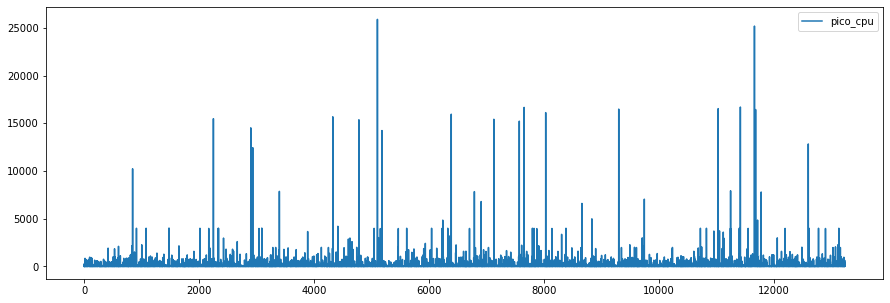

In [8]:
df_group_by_max_cpu.plot(figsize=(15, 5))

In [9]:
# Agrupa as aplicações e agrega pelo valor da mediana dos valores de consumo de CPU por aplicação
df_group_by_med_cpu = df_consolidado_cpu.groupby(['hash']).median()
# Reseta o índice
df_group_by_med_cpu.reset_index(inplace=True)
df_group_by_med_cpu = df_group_by_med_cpu.rename(columns = {'consumo_cpu':'mediana_cpu'})
df_group_by_med_cpu

,hash,mediana_cpu
0,0008019539e8167e69236ac2ea9ae47e,0.911453
1,00115d136a63167e961d60147809aff7,149.904429
2,0012e711c5c46e63dc1e77562687f116,17.083225
3,00171f1ecb4cb384c73b460e424033ae,8.067401
4,00192f6f6f4e5a93d8d562202c6d0227,0.926145
...,...,...
13227,ffe7450b3571c80c26389cd403b6017c,3.622475
13228,ffe9a18ad951c33d19abd5db90427e09,0.047840
13229,fff0224bd494974fed97e73b5dc186f0,89.314531
13230,fff13383e3a6e8b8cc87a597f9fc8272,3.989787


<AxesSubplot:>

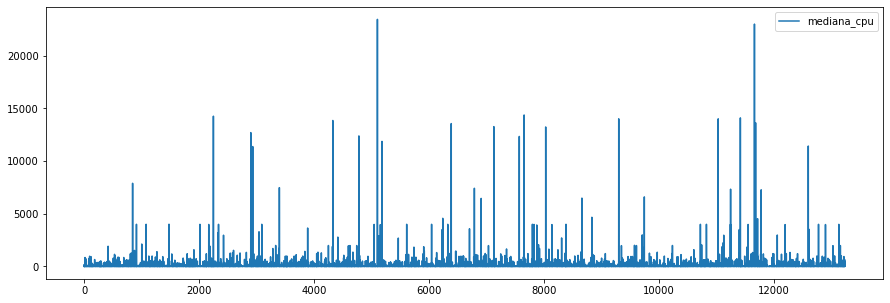

In [10]:
df_group_by_med_cpu.plot(figsize=(15, 5))

Percebe-se uma mesma tendência entre os valores de pico e mediana obtidos do consumo de CPU para as aplicações. O que reforça o uso da mediana como uma boa opção de representação de medida de tendência central.

### Agregação de Memória

In [11]:
## Agregação dos dados de Memória
path_processados_memoria = '/dados/metrics/memoria/processados'
csv_file_consolidado_memoria = f'{path_projeto}{path_processados_memoria}/consolidado_memoria.csv'
df_consolidado_memoria = pd.read_csv(csv_file_consolidado_memoria, sep=',',decimal='.')
df_consolidado_memoria

,hash,hora,min,consumo_memoria
0,ce4468ee8389709c20b40ed1c09a36c1,7,30,1706799104
1,0dcf61756612a9edfc06d254802e4b28,7,30,1880600576
2,19d9963e0460ed384a60ef724eb79ba0,7,30,1742057472
3,71fda736ff39dfe174e01df9d489ee11,7,30,972967936
4,1e300feefc2f05d7e69bbae4dd0a7bda,7,30,2030047232
...,...,...,...,...
1120603,549e6de29086031460e6dc2b5b5a23b2,0,30,321482752
1120604,923e73720e11ced1e0278319563d4002,0,30,319995904
1120605,3d72b13248e9c2655339a30d6cac122c,0,30,296550400
1120606,71616988da26ec9cb9d4c031498c9379,0,30,266776576


In [12]:
# Remove os valores zerados de consumo de memória
df_consolidado_memoria = df_consolidado_memoria[df_consolidado_memoria['consumo_memoria'] > 0]
df_consolidado_memoria

,hash,hora,min,consumo_memoria
0,ce4468ee8389709c20b40ed1c09a36c1,7,30,1706799104
1,0dcf61756612a9edfc06d254802e4b28,7,30,1880600576
2,19d9963e0460ed384a60ef724eb79ba0,7,30,1742057472
3,71fda736ff39dfe174e01df9d489ee11,7,30,972967936
4,1e300feefc2f05d7e69bbae4dd0a7bda,7,30,2030047232
...,...,...,...,...
1120603,549e6de29086031460e6dc2b5b5a23b2,0,30,321482752
1120604,923e73720e11ced1e0278319563d4002,0,30,319995904
1120605,3d72b13248e9c2655339a30d6cac122c,0,30,296550400
1120606,71616988da26ec9cb9d4c031498c9379,0,30,266776576


In [13]:
# Exclui a coluna de hora e minuto
del df_consolidado_memoria['hora']
del df_consolidado_memoria['min']
df_consolidado_memoria

,hash,consumo_memoria
0,ce4468ee8389709c20b40ed1c09a36c1,1706799104
1,0dcf61756612a9edfc06d254802e4b28,1880600576
2,19d9963e0460ed384a60ef724eb79ba0,1742057472
3,71fda736ff39dfe174e01df9d489ee11,972967936
4,1e300feefc2f05d7e69bbae4dd0a7bda,2030047232
...,...,...
1120603,549e6de29086031460e6dc2b5b5a23b2,321482752
1120604,923e73720e11ced1e0278319563d4002,319995904
1120605,3d72b13248e9c2655339a30d6cac122c,296550400
1120606,71616988da26ec9cb9d4c031498c9379,266776576


In [14]:
## Connverte o valor de consumo de memória de bytes para MB
df_consolidado_memoria['consumo_memoria'] = df_consolidado_memoria['consumo_memoria'] / (1024 * 1024)
df_consolidado_memoria

/tmp/ipykernel_30177/3340153147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consolidado_memoria['consumo_memoria'] = df_consolidado_memoria['consumo_memoria'] / (1024 * 1024)


,hash,consumo_memoria
0,ce4468ee8389709c20b40ed1c09a36c1,1627.730469
1,0dcf61756612a9edfc06d254802e4b28,1793.480469
2,19d9963e0460ed384a60ef724eb79ba0,1661.355469
3,71fda736ff39dfe174e01df9d489ee11,927.894531
4,1e300feefc2f05d7e69bbae4dd0a7bda,1936.003906
...,...,...
1120603,549e6de29086031460e6dc2b5b5a23b2,306.589844
1120604,923e73720e11ced1e0278319563d4002,305.171875
1120605,3d72b13248e9c2655339a30d6cac122c,282.812500
1120606,71616988da26ec9cb9d4c031498c9379,254.417969


In [15]:
## Estatística do dado
df_consolidado_memoria.describe()

,consumo_memoria
count,1.120607e+06
mean,4.346852e+02
std,8.952353e+02
min,1.796875e-01
25%,4.303906e+01
50%,2.230312e+02
75%,5.499414e+02
max,3.930253e+04


75 % dos dados apresentam um valor de consumo de memória menor que 550MB

In [16]:
# Obtenção do Pico de Memória por aplicação
df_group_by_max_memoria = df_consolidado_memoria.groupby(['hash']).max()
# Reseta o índice
df_group_by_max_memoria.reset_index(inplace=True)
df_group_by_max_memoria = df_group_by_max_memoria.rename(columns = {'consumo_memoria':'pico_memoria'})
df_group_by_max_memoria

,hash,pico_memoria
0,0008019539e8167e69236ac2ea9ae47e,2.648438
1,00115d136a63167e961d60147809aff7,199.488281
2,0012e711c5c46e63dc1e77562687f116,315.667969
3,00171f1ecb4cb384c73b460e424033ae,134.796875
4,00192f6f6f4e5a93d8d562202c6d0227,485.429688
...,...,...
17746,fff0224bd494974fed97e73b5dc186f0,614.652344
17747,fff13383e3a6e8b8cc87a597f9fc8272,3811.453125
17748,fff4fbecc90f7a87bce08f96b5441d3e,0.183594
17749,fff602eaae3069b08241eb3d38862349,3883.945312


<AxesSubplot:ylabel='memoria (Mb)'>

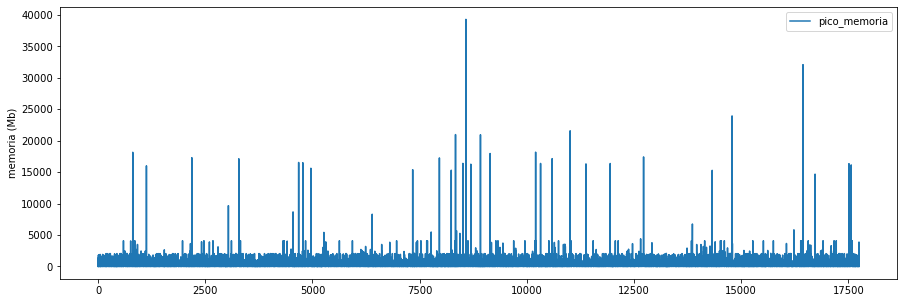

In [17]:
df_group_by_max_memoria.plot(ylabel='memoria (Mb)', figsize=(15, 5))

In [18]:
# Obtenção da Mediana de Consumo de Memória
df_group_by_med_memoria = df_consolidado_memoria.groupby(['hash']).median()
# Reseta o índice
df_group_by_med_memoria.reset_index(inplace=True)
df_group_by_med_memoria = df_group_by_med_memoria.rename(columns = {'consumo_memoria':'mediana_memoria'})
df_group_by_med_memoria

,hash,mediana_memoria
0,0008019539e8167e69236ac2ea9ae47e,1.878906
1,00115d136a63167e961d60147809aff7,199.113281
2,0012e711c5c46e63dc1e77562687f116,192.505859
3,00171f1ecb4cb384c73b460e424033ae,126.757812
4,00192f6f6f4e5a93d8d562202c6d0227,485.292969
...,...,...
17746,fff0224bd494974fed97e73b5dc186f0,554.339844
17747,fff13383e3a6e8b8cc87a597f9fc8272,3788.033203
17748,fff4fbecc90f7a87bce08f96b5441d3e,0.183594
17749,fff602eaae3069b08241eb3d38862349,2988.871094


<AxesSubplot:ylabel='memoria (Mb)'>

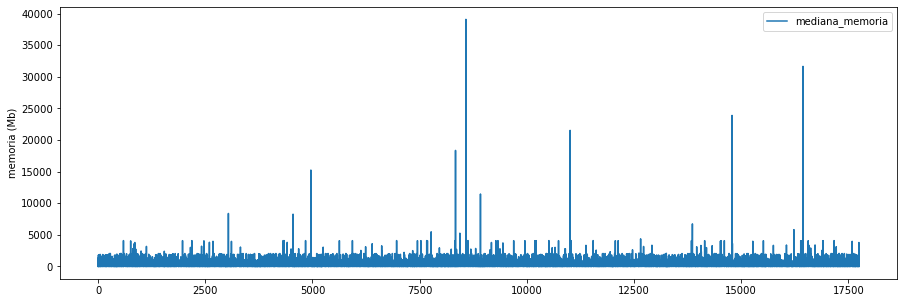

In [19]:
df_group_by_med_memoria.plot(ylabel='memoria (Mb)', figsize=(15, 5))

### Agregação dos valores de consumo de CPU e Memória

In [20]:
# Realizando o join do consumo de memória e cpu
# Agregação das colunas de valores mediana e pico da CPU
df_group_by_cpu = pd.concat([df_group_by_med_cpu.set_index('hash'),df_group_by_max_cpu.set_index('hash')], axis=1, join='inner').reset_index()

# Agregação das colunas de valores mediana e pico da Memoria
df_group_by_memoria = pd.concat([df_group_by_med_memoria.set_index('hash'),df_group_by_max_memoria.set_index('hash')], axis=1, join='inner').reset_index()

# Agregação das colunas de CPU e Memoria
df_group_by_cpu_memoria = pd.concat([df_group_by_cpu.set_index('hash'),df_group_by_memoria.set_index('hash')], axis=1, join='inner').reset_index()
df_group_by_cpu_memoria

,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria
0,0008019539e8167e69236ac2ea9ae47e,0.911453,3.650762,1.878906,2.648438
1,00115d136a63167e961d60147809aff7,149.904429,271.180115,199.113281,199.488281
2,0012e711c5c46e63dc1e77562687f116,17.083225,79.644258,192.505859,315.667969
3,00171f1ecb4cb384c73b460e424033ae,8.067401,47.315712,126.757812,134.796875
4,00192f6f6f4e5a93d8d562202c6d0227,0.926145,1.039340,485.292969,485.429688
...,...,...,...,...,...
13227,ffe7450b3571c80c26389cd403b6017c,3.622475,9.803999,182.056641,249.277344
13228,ffe9a18ad951c33d19abd5db90427e09,0.047840,0.539145,40.437500,97.980469
13229,fff0224bd494974fed97e73b5dc186f0,89.314531,105.384126,554.339844,614.652344
13230,fff13383e3a6e8b8cc87a597f9fc8272,3.989787,45.809739,3788.033203,3811.453125


### Remoção da aplicações com execuções além dos recursos de cpu e memória

Remove as aplicações que sofreram erro por estouro de Limite de Memória (erro do tipo **OOMKilled**) ou que tem excesso de consumo de CPU (throttled). 
Por simplificação, essas aplicações serão desconsideradas da amostra.

In [21]:
## Agrupa as aplicacoes com estouro de memória
path_processados_error = '/dados/metrics/error/processados'
csv_file_consolidado_error = f'{path_projeto}{path_processados_error}/consolidado_error.csv'
df_consolidado_error_memoria = pd.read_csv(csv_file_consolidado_error, sep=',',decimal='.')
## Agrega as aplicações pelo o hash de identificação
df_aplicacoes_error_memoria = df_consolidado_error_memoria['hash'].unique()
df_aplicacoes_error_memoria.shape

(611,)

In [22]:
## Remove as aplicaçoes com erro de memória do dataframe consolidado
df_group_by_cpu_memoria = df_group_by_cpu_memoria[~df_group_by_cpu_memoria['hash'].isin(df_aplicacoes_error_memoria)]
df_group_by_cpu_memoria

,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria
0,0008019539e8167e69236ac2ea9ae47e,0.911453,3.650762,1.878906,2.648438
1,00115d136a63167e961d60147809aff7,149.904429,271.180115,199.113281,199.488281
2,0012e711c5c46e63dc1e77562687f116,17.083225,79.644258,192.505859,315.667969
3,00171f1ecb4cb384c73b460e424033ae,8.067401,47.315712,126.757812,134.796875
4,00192f6f6f4e5a93d8d562202c6d0227,0.926145,1.039340,485.292969,485.429688
...,...,...,...,...,...
13227,ffe7450b3571c80c26389cd403b6017c,3.622475,9.803999,182.056641,249.277344
13228,ffe9a18ad951c33d19abd5db90427e09,0.047840,0.539145,40.437500,97.980469
13229,fff0224bd494974fed97e73b5dc186f0,89.314531,105.384126,554.339844,614.652344
13230,fff13383e3a6e8b8cc87a597f9fc8272,3.989787,45.809739,3788.033203,3811.453125


In [23]:
## Agrupa as aplicacoes com excesso de cpu (throttled)
path_processados_throttled = '/dados/metrics/throttled/processados'
csv_file_consolidado_throttled = f'{path_projeto}{path_processados_throttled}/consolidado_cpu_throttled.csv'
df_consolidado_throttled = pd.read_csv(csv_file_consolidado_throttled, sep=',',decimal='.')
## Agrega as aplicações pelo o hash de identificação
df_consolidado_throttled = df_consolidado_throttled['hash'].unique()
df_consolidado_throttled.shape

(1378,)

In [24]:
## Remove as aplicaçoes com erro de memória do dataframe consolidado
df_group_by_cpu_memoria = df_group_by_cpu_memoria[~df_group_by_cpu_memoria['hash'].isin(df_consolidado_throttled)]
df_group_by_cpu_memoria.reset_index(drop=True)

,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria
0,0008019539e8167e69236ac2ea9ae47e,0.911453,3.650762,1.878906,2.648438
1,00115d136a63167e961d60147809aff7,149.904429,271.180115,199.113281,199.488281
2,0012e711c5c46e63dc1e77562687f116,17.083225,79.644258,192.505859,315.667969
3,00171f1ecb4cb384c73b460e424033ae,8.067401,47.315712,126.757812,134.796875
4,00192f6f6f4e5a93d8d562202c6d0227,0.926145,1.039340,485.292969,485.429688
...,...,...,...,...,...
11446,ffd57b1dd0bbae7965fe5dadb86232d3,1.581423,1.964469,49.019531,51.496094
11447,ffd950eb6ceeacfbd2f239eb34679cbe,1.539080,10.541363,622.871094,624.640625
11448,ffe0c98ba8be743bf086d4e7af181823,0.717605,0.913246,101.005859,105.875000
11449,ffe9a18ad951c33d19abd5db90427e09,0.047840,0.539145,40.437500,97.980469


<AxesSubplot:ylabel='memoria (Mb)'>

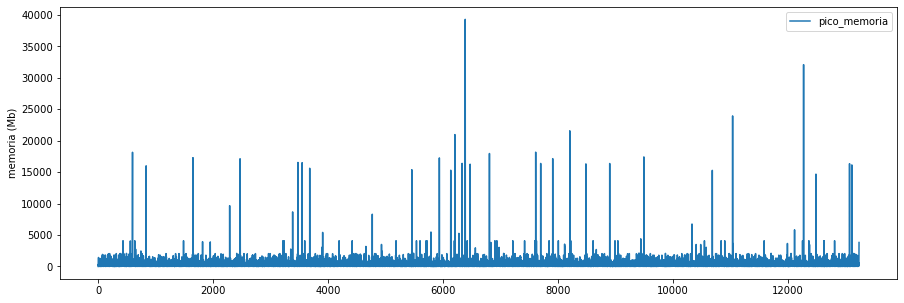

In [25]:
# Pico de Memória após a eliminação de algumas aplicações com excesso de consumo de recursos
df_group_by_max_memoria = df_group_by_cpu_memoria.iloc[:, [0,4]] # colunas hash e pico_memoria
df_group_by_max_memoria.plot(ylabel='memoria (Mb)', figsize=(15, 5))

<AxesSubplot:ylabel='CPU mCPUs'>

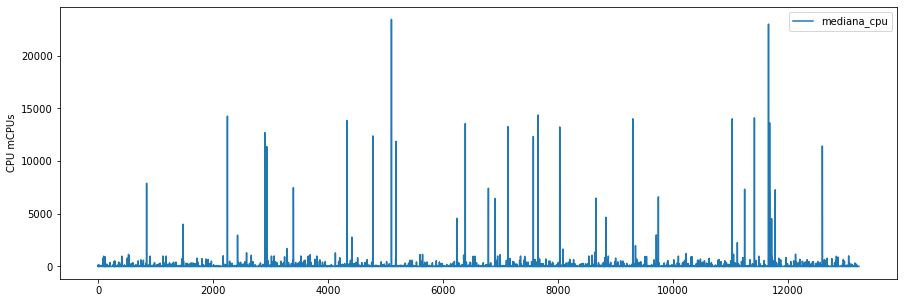

In [26]:
# Mediana do consumo de CPU após a eliminação de algumas aplicações com excesso de consumo de recursos
df_group_by_med_cpu = df_group_by_cpu_memoria.iloc[:, [0,1]] # colunas hash e mediana_cpu
df_group_by_med_cpu.plot(ylabel='CPU mCPUs', figsize=(15, 5))

<AxesSubplot:xlabel='CPU mCPUs', ylabel='Memória MB'>

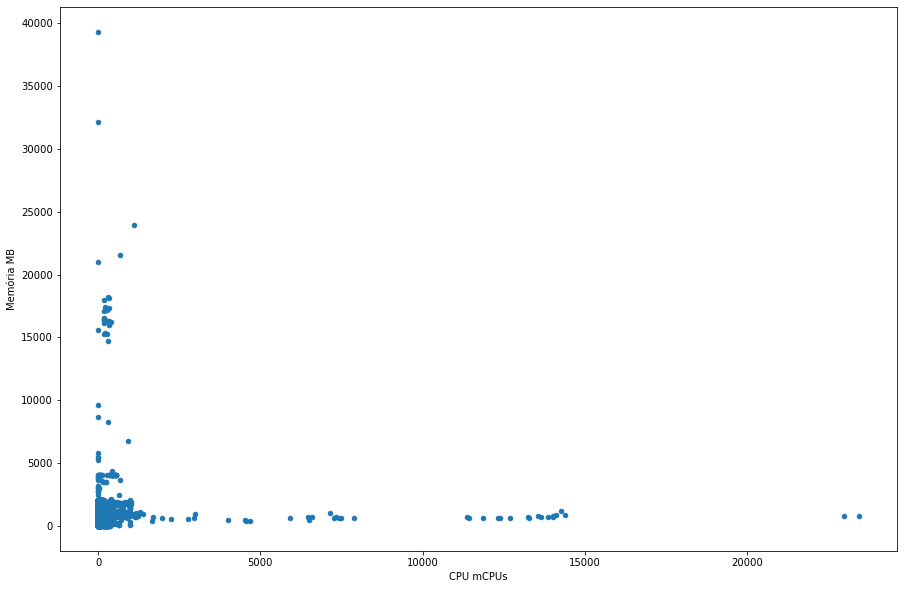

In [27]:
df_group_by_cpu_memoria.plot.scatter(x='mediana_cpu', y='pico_memoria', rot=0, figsize=(15, 10), xlabel='CPU mCPUs', ylabel='Memória MB')

O desenho apresenta uma grande concentração de aplicações com valores de média de consumo de CPU e memoria com pequenos valores.

# Exploração de dados com KMeans
- https://realpython.com/k-means-clustering-python/
- https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203


## Abordagem 1

### Hierarchical Clustering

Hierarchical clustering determines cluster assignments by building a hierarchy. This is implemented by either a bottom-up or a top-down approach:
- Divisive clustering is the top-down approach. It starts with all points as one cluster and splits the least similar clusters at each step until only single data points remain. 

Hierarchical clustering is a deterministic process, meaning cluster assignments won’t change when you run an algorithm twice on the same input data.

The strengths of hierarchical clustering methods include the following:

    They often reveal the finer details about the relationships between data objects.
    They provide an interpretable dendrogram.

The weaknesses of hierarchical clustering methods include the following:

    They’re computationally expensive with respect to algorithm complexity.
    They’re sensitive to noise and outliers.

## Abordagem 2

### Density-Based Clustering

Density-based clustering determines cluster assignments based on the density of data points in a region. Clusters are assigned where there are high densities of data points separated by low-density regions.

Unlike the other clustering categories, this approach doesn’t require the user to specify the number of clusters. Instead, there is a distance-based parameter that acts as a tunable threshold. This threshold determines how close points must be to be considered a cluster member.

Examples of density-based clustering algorithms include Density-Based Spatial Clustering of Applications with Noise, or DBSCAN, and Ordering Points To Identify the Clustering Structure, or OPTICS.

The strengths of density-based clustering methods include the following:

    They excel at identifying clusters of nonspherical shapes.
    They’re resistant to outliers.

The weaknesses of density-based clustering methods include the following:

    They aren’t well suited for clustering in high-dimensional spaces.
    They have trouble identifying clusters of varying densities.


In [28]:
df_group_by_cpu_memoria.shape

(11451, 5)

In [29]:
# Pré-processamento
from sklearn import preprocessing
import numpy as np

In [30]:
# Processo de Normalização dos dados
df_group_by_cpu_memoria_normalized = df_group_by_cpu_memoria.to_numpy()
df_group_by_cpu_memoria_normalized

array([['0008019539e8167e69236ac2ea9ae47e', 0.9114531943193,
        3.6507621287416, 1.87890625, 2.6484375],
       ['00115d136a63167e961d60147809aff7', 149.90442886482504,
        271.1801154295211, 199.11328125, 199.48828125],
       ['0012e711c5c46e63dc1e77562687f116', 17.0832246981934,
        79.6442577799162, 192.505859375, 315.66796875],
       ...,
       ['ffe0c98ba8be743bf086d4e7af181823', 0.71760542242,
        0.9132455222309, 101.005859375, 105.875],
       ['ffe9a18ad951c33d19abd5db90427e09', 0.0478402125234,
        0.5391452306609, 40.4375, 97.98046875],
       ['fff13383e3a6e8b8cc87a597f9fc8272', 3.9897866712861996,
        45.809738851979695, 3788.033203125, 3811.453125]], dtype=object)

In [31]:
# Features consideradas (mediana da CPU e Pico de Memória)
df_group_by_cpu_memoria_normalized = np.delete(df_group_by_cpu_memoria_normalized, 0, axis=1) # Deleta hash
df_group_by_cpu_memoria_normalized = np.delete(df_group_by_cpu_memoria_normalized, 1, axis=1) # Deleta pico cpu
df_group_by_cpu_memoria_normalized = np.delete(df_group_by_cpu_memoria_normalized, 1, axis=1) # Deleta mediana da memoria
df_group_by_cpu_memoria_normalized

array([[0.9114531943193, 2.6484375],
       [149.90442886482504, 199.48828125],
       [17.0832246981934, 315.66796875],
       ...,
       [0.71760542242, 105.875],
       [0.0478402125234, 97.98046875],
       [3.9897866712861996, 3811.453125]], dtype=object)

In [32]:
# Normalizacao
scaler = preprocessing.StandardScaler().fit(df_group_by_cpu_memoria_normalized)
scaler

StandardScaler()

In [33]:
scaled_features = scaler.transform(df_group_by_cpu_memoria_normalized)
scaled_features

array([[-0.08847088, -0.4140462 ],
       [ 0.14753639, -0.23015733],
       [-0.06285454, -0.12162162],
       ...,
       [-0.08877794, -0.31761137],
       [-0.08983886, -0.32498649],
       [-0.08359475,  3.14416022]])

In [34]:
# Scaled data has zero mean and unit variance:
print(f' Média {scaled_features.mean(axis=0)}\n Desvio Padrão {scaled_features.std(axis=0)}')

 Média [-1.48921716e-17 -1.42716644e-17]
 Desvio Padrão [1. 1.]


#### Aplicação do K-Means

In [35]:
from sklearn.cluster import KMeans

## Determinação do Número de Cluster pela técnica ebow

In [36]:
distortions = []
n_clusters = range(2, 10)
for n in n_clusters:    
    print('Cluster ', n)
    distortions.append(KMeans(n_clusters=n, n_init=100, max_iter=10_000, random_state=61658).fit(scaled_features).inertia_)
distortions

Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9


[13400.493877330358,
 5401.272529534381,
 3762.8659160945112,
 2770.187340000388,
 2201.2637188561116,
 1699.4506161592083,
 1246.939723212176,
 910.5636941469222]

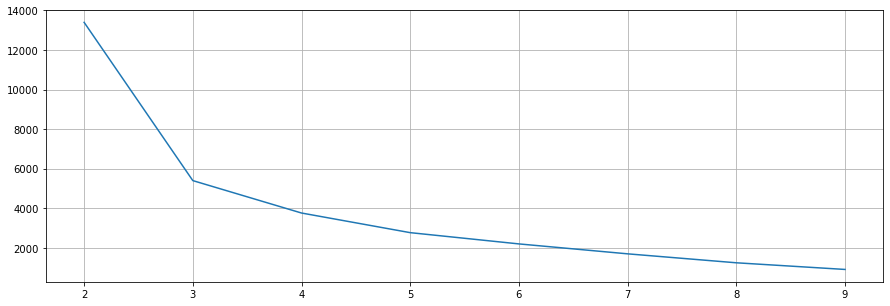

In [37]:
plt.figure(figsize=(15,5))
plt.plot(n_clusters, distortions)
plt.grid()

In [38]:
# Treinamento com 3 classes (Cluster = 3)
qtd_clusters=3
kmeans = KMeans(n_clusters=qtd_clusters, n_init=100, max_iter=10_000, random_state=61658).fit(scaled_features)


In [39]:
# Statistics from the initialization run with the lowest SSE 
# are available as attributes of kmeans after calling .fit():
# The lowest SSE value
kmeans.inertia_

5401.272529534381

In [40]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-0.04515756, -0.04285101],
       [ 0.30080246, 16.58295798],
       [18.73507779,  0.27338824]])

In [41]:
# The number of iterations required to converge
kmeans.n_iter_

3

In [42]:
# The cluster assignments are stored as a one-dimensional NumPy array in kmeans.labels_.
kmeans.labels_[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [ ]:
# Função de Normalização de Max-Min
# Mean normalization
# (df-df.mean())/df.std()
# def normalize(df):
#     result = df.copy()
#     for feature_name in df.columns:
#         if feature_name != 'hash':
#             max_value = df[feature_name].max()
#             min_value = df[feature_name].min()
#             result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#     return result

In [43]:
len(kmeans.labels_)

11451

In [44]:
series_label = pd.Series(kmeans.labels_)
series_label

0        0
1        0
2        0
3        0
4        0
        ..
11446    0
11447    0
11448    0
11449    0
11450    0
Length: 11451, dtype: int32

In [45]:
# Adiciona a série ao dataframe
df_group_by_cpu_memoria['classe'] = kmeans.labels_
df_group_by_cpu_memoria

/tmp/ipykernel_30177/628503271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group_by_cpu_memoria['classe'] = kmeans.labels_


,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria,classe
0,0008019539e8167e69236ac2ea9ae47e,0.911453,3.650762,1.878906,2.648438,0
1,00115d136a63167e961d60147809aff7,149.904429,271.180115,199.113281,199.488281,0
2,0012e711c5c46e63dc1e77562687f116,17.083225,79.644258,192.505859,315.667969,0
3,00171f1ecb4cb384c73b460e424033ae,8.067401,47.315712,126.757812,134.796875,0
4,00192f6f6f4e5a93d8d562202c6d0227,0.926145,1.039340,485.292969,485.429688,0
...,...,...,...,...,...,...
13222,ffd57b1dd0bbae7965fe5dadb86232d3,1.581423,1.964469,49.019531,51.496094,0
13223,ffd950eb6ceeacfbd2f239eb34679cbe,1.539080,10.541363,622.871094,624.640625,0
13226,ffe0c98ba8be743bf086d4e7af181823,0.717605,0.913246,101.005859,105.875000,0
13228,ffe9a18ad951c33d19abd5db90427e09,0.047840,0.539145,40.437500,97.980469,0


In [46]:
scaled_features[:,0]

array([-0.08847088,  0.14753639, -0.06285454, ..., -0.08877794,
       -0.08983886, -0.08359475])

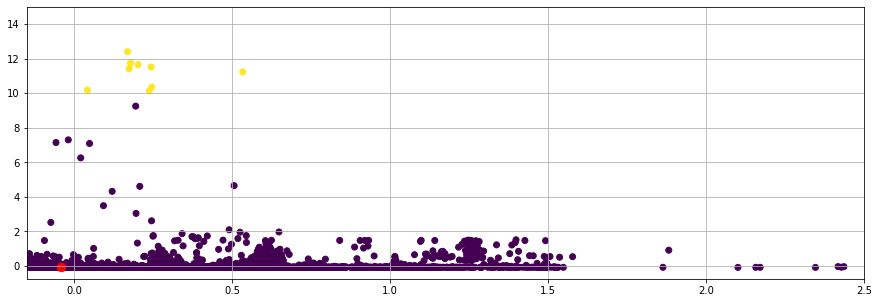

In [47]:
plt.figure(figsize=(15,5)) 
plt.scatter(scaled_features[:,1], scaled_features[:,0], c = kmeans.labels_) #posicionamento dos eixos x e y
plt.xlim(-0.15,2.5) #range do eixo x
plt.ylim(-0.75, 15) #range do eixo y

# plt.scatter(df_group_by_cpu_memoria['mediana_cpu'], df_group_by_cpu_memoria['mediana_memoria'], c = df_group_by_cpu_memoria['classe']) #posicionamento dos eixos x e y
# plt.xlabel('Memória MB')
# plt.ylabel('CPU mCPUs')
# plt.xlim(0, 8000) #range do eixo x
# plt.ylim(0, 10000) #range do eixo y
plt.grid() #função que desenha a grade no nosso gráfico
plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0], s = 70, c = 'red') #posição de cada centroide no gráfico

plt.show()

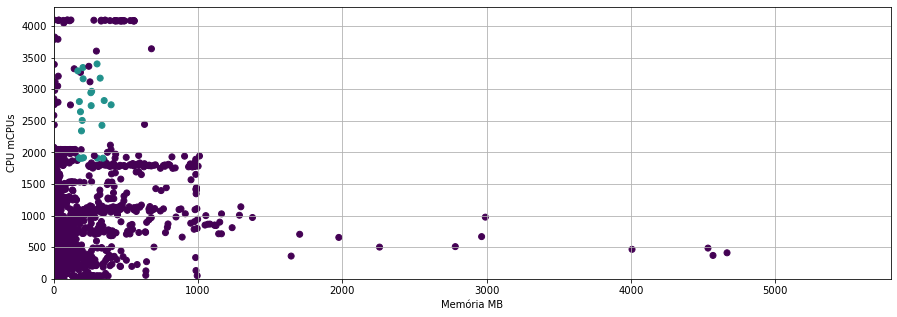

In [48]:
# plt.scatter(scaled_features[:,1], scaled_features[:,0], c = kmeans.labels_) #posicionamento dos eixos x e y
# plt.xlim(-0.15, 25) #range do eixo x
# plt.ylim(-0.75, 35) #range do eixo y
plt.figure(figsize=(15,5)) 
plt.scatter(df_group_by_cpu_memoria['mediana_cpu'], df_group_by_cpu_memoria['mediana_memoria'], c = df_group_by_cpu_memoria['classe']) #posicionamento dos eixos x e y
plt.xlabel('Memória MB')
plt.ylabel('CPU mCPUs')
plt.xlim(0, 5800) #range do eixo x
plt.ylim(0, 4300) #range do eixo y
plt.grid() #função que desenha a grade no nosso gráfico
plt.show()

## Restrição dos dados removendo as amostras com valores mais discrepantes

In [100]:
df_group_by_cpu_memoria

,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria,classe
3,00192f6f6f4e5a93d8d562202c6d0227,0.916936,1.031100,485.265625,485.390625,1
4,0024f1a3bde07d1c2849af7a4e2b05f2,0.411342,0.449723,30.335938,30.460938,3
7,00397e755d86f88d58f23419ce8ba8e8,0.001536,0.002612,11.078125,11.082031,3
8,003c3255c6f292d40085b45189c83b23,0.115973,0.146571,241.890625,241.906250,5
10,004428b1faa8b72bc0d20064b5f005e0,0.002421,0.005926,3.343750,3.531250,3
...,...,...,...,...,...,...
13082,ffab0a2627a30b7caef9bb3c2ad72314,0.000646,0.000783,1.714844,1.714844,3
13084,ffaf08c9bc5fb2ed3665bd9b0e4f9389,0.619316,0.682982,300.304688,307.144531,5
13087,ffbff6083eb234b26af881f5adbde374,1.170667,1.492713,331.789062,331.859375,1
13088,ffc59295b896b7b22280d0bf1be0699d,0.057966,0.158400,32.550781,32.792969,3


In [106]:
df_group_by_cpu_memoria['pico_memoria'].describe()

count    6945.000000
mean      161.109252
std       160.439332
min         1.472656
25%        23.628906
50%        96.703125
75%       288.531250
max       537.773438
Name: pico_memoria, dtype: float64

In [107]:
df_group_by_cpu_memoria['mediana_cpu'].describe()

count    6945.000000
mean        1.107135
std         1.137059
min         0.000097
25%         0.157719
50%         0.799543
75%         1.563706
max         5.037434
Name: mediana_cpu, dtype: float64

In [85]:
# Considerando os 75% mais frequentes do valor médio (mediana) de CPU e valor máximo de memória (pico)
df_group_by_cpu_memoria = df_group_by_cpu_memoria[df_group_by_cpu_memoria['mediana_cpu'] < 5.04]
df_group_by_cpu_memoria = df_group_by_cpu_memoria[df_group_by_cpu_memoria['pico_memoria'] < 538]
df_group_by_cpu_memoria

,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria,classe
3,00192f6f6f4e5a93d8d562202c6d0227,0.916936,1.031100,485.265625,485.390625,0
4,0024f1a3bde07d1c2849af7a4e2b05f2,0.411342,0.449723,30.335938,30.460938,0
7,00397e755d86f88d58f23419ce8ba8e8,0.001536,0.002612,11.078125,11.082031,0
8,003c3255c6f292d40085b45189c83b23,0.115973,0.146571,241.890625,241.906250,0
10,004428b1faa8b72bc0d20064b5f005e0,0.002421,0.005926,3.343750,3.531250,0
...,...,...,...,...,...,...
13082,ffab0a2627a30b7caef9bb3c2ad72314,0.000646,0.000783,1.714844,1.714844,0
13084,ffaf08c9bc5fb2ed3665bd9b0e4f9389,0.619316,0.682982,300.304688,307.144531,0
13087,ffbff6083eb234b26af881f5adbde374,1.170667,1.492713,331.789062,331.859375,0
13088,ffc59295b896b7b22280d0bf1be0699d,0.057966,0.158400,32.550781,32.792969,0


In [86]:
# Redução da amostra para ~60%
# Processo de Normalização
df_group_by_cpu_memoria_normalized = df_group_by_cpu_memoria.to_numpy()
df_group_by_cpu_memoria_normalized

# Consideração de Valores Médios (Mediana)
df_group_by_cpu_memoria_normalized = np.delete(df_group_by_cpu_memoria_normalized, 0, axis=1) # Deleta hash
df_group_by_cpu_memoria_normalized = np.delete(df_group_by_cpu_memoria_normalized, 1, axis=1) # Deleta pico cpu
df_group_by_cpu_memoria_normalized = np.delete(df_group_by_cpu_memoria_normalized, 1, axis=1) # Deleta mediana da memoria
# Features consideradas (mediana da CPU e Pico de Memória)
df_group_by_cpu_memoria_normalized

# Deleta a classe para uma nova classificação
df_group_by_cpu_memoria_normalized = np.delete(
df_group_by_cpu_memoria_normalized, 2, axis=1) # Deleta classe

In [87]:
# Normalizacao
scaler = preprocessing.StandardScaler().fit(df_group_by_cpu_memoria_normalized)

# Obtencao das features normalizadas
scaled_features = scaler.transform(df_group_by_cpu_memoria_normalized)
scaled_features

array([[-0.16728436,  2.02135423],
       [-0.61196739, -0.81437463],
       [-0.97240211, -0.93516983],
       ...,
       [ 0.05587804,  1.06434261],
       [-0.92277044, -0.7998383 ],
       [ 0.39708129, -0.68873398]])

Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9


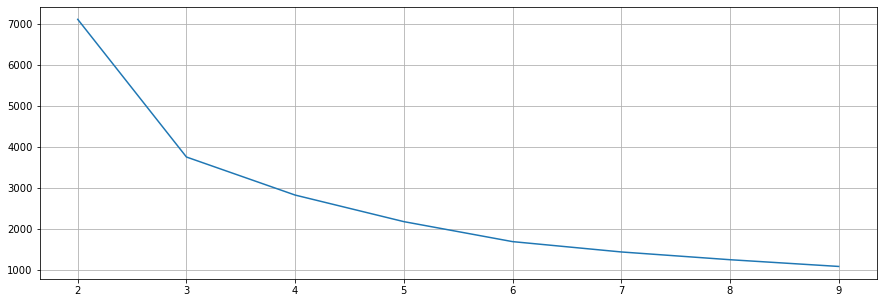

In [88]:
# Determinação do Número de Clusters
distortions = []
n_clusters = range(2, 10)
for n in n_clusters:    
    print('Cluster ', n)
    distortions.append(KMeans(n_clusters=n, n_init=100, max_iter=10_000, random_state=61658).fit(scaled_features).inertia_)
distortions

plt.figure(figsize=(15,5))
plt.plot(n_clusters, distortions)
plt.grid()

In [95]:
# Treinamento com 3 classes (Cluster = 3)
kmeans = KMeans(n_clusters=6, n_init=100, max_iter=10_000, random_state=61658).fit(scaled_features)

# Adiciona os labels ao dataframe
df_group_by_cpu_memoria['classe'] = kmeans.labels_
df_group_by_cpu_memoria

,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria,classe
3,00192f6f6f4e5a93d8d562202c6d0227,0.916936,1.031100,485.265625,485.390625,1
4,0024f1a3bde07d1c2849af7a4e2b05f2,0.411342,0.449723,30.335938,30.460938,3
7,00397e755d86f88d58f23419ce8ba8e8,0.001536,0.002612,11.078125,11.082031,3
8,003c3255c6f292d40085b45189c83b23,0.115973,0.146571,241.890625,241.906250,5
10,004428b1faa8b72bc0d20064b5f005e0,0.002421,0.005926,3.343750,3.531250,3
...,...,...,...,...,...,...
13082,ffab0a2627a30b7caef9bb3c2ad72314,0.000646,0.000783,1.714844,1.714844,3
13084,ffaf08c9bc5fb2ed3665bd9b0e4f9389,0.619316,0.682982,300.304688,307.144531,5
13087,ffbff6083eb234b26af881f5adbde374,1.170667,1.492713,331.789062,331.859375,1
13088,ffc59295b896b7b22280d0bf1be0699d,0.057966,0.158400,32.550781,32.792969,3


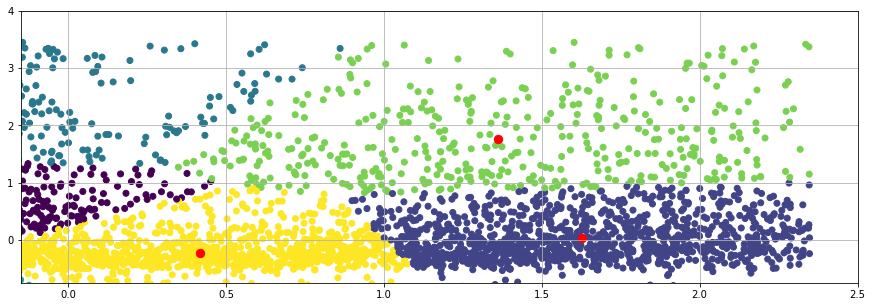

In [96]:
# Gráficos dos valores das features normalizadas
plt.figure(figsize=(15,5))
plt.scatter(scaled_features[:,1], scaled_features[:,0], c = kmeans.labels_) #posicionamento dos eixos x e y
plt.xlim(-0.15,2.5) #range do eixo x
plt.ylim(-0.75, 4) #range do eixo y

# plt.scatter(df_group_by_cpu_memoria['mediana_cpu'], df_group_by_cpu_memoria['mediana_memoria'], c = df_group_by_cpu_memoria['classe']) #posicionamento dos eixos x e y
# plt.xlabel('Memória MB')
# plt.ylabel('CPU mCPUs')
# plt.xlim(0, 8000) #range do eixo x
# plt.ylim(0, 10000) #range do eixo y
plt.grid() #função que desenha a grade no nosso gráfico
plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0], s = 70, c = 'red') #posição de cada centroide no gráfico
plt.show()

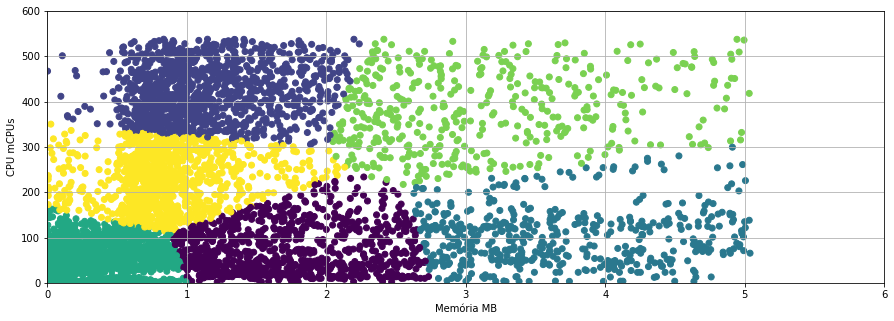

In [98]:
# Gráfico a partir dos valores originais
plt.figure(figsize=(15,5))
plt.scatter(df_group_by_cpu_memoria['mediana_cpu'], df_group_by_cpu_memoria['pico_memoria'], c = df_group_by_cpu_memoria['classe']) #posicionamento dos eixos x e y
plt.xlabel('Memória MB')
plt.ylabel('CPU mCPUs')
plt.xlim(0, 6) #range do eixo x
plt.ylim(0, 600) #range do eixo y
plt.grid() #função que desenha a grade no nosso gráfico
plt.show()

In [99]:
data_flavors = {'flavor': ['m0','m1','m2','m3','m4','m5','m6','m7','m8','m9', 'n2'],
          'mCPU': [4, 8,16, 24, 32, 48, 64, 80, 96, 96, 256],
          'memoria': [64, 128, 256, 384, 512, 768, 1024, 1280, 1536, 2048, 4096]
        }

df_flavors = pd.DataFrame(data_flavors)
df_flavors

,flavor,mCPU,memoria
0,m0,4,64
1,m1,8,128
2,m2,16,256
3,m3,24,384
4,m4,32,512
5,m5,48,768
6,m6,64,1024
7,m7,80,1280
8,m8,96,1536
9,m9,96,2048


##  Rotulação

A rotulação consideração uma nova classificação de flavors baseada uma variação de menor de consumo de CPU que será denominada de f, variando de 0 a 1 (f0, f1, f2, f3, f4, f5)

O delta do flavor do limite de memória e consumo de CPU será obtido entre os valores máximo e mínimos de cada métrica dividido em 6 partes.

(&#916;)Memoria = Max(Pico Memoria) / 6 ~ 600 / 6 = 100 MB

(&#916;)CPU = Max(Mediana da CPU) / 6 ~ 6 / 6 = 1mCPU

Desta forma, a classificação de flavors fica:

flavor | mCPU | MB
--| -- |--
f0|1mCPU|100MB
f1|2mCPU|200MB
f2|3mCPU|300MB
f3|4mCPU|400MB
f4|5mCPU|500MB
f5|6mCPU|600MB


In [146]:
def rotular(cpu, memoria):    
    if cpu <= 1 and memoria <= 100:
        return 'f0'
    if cpu <= 2 and memoria <= 200:
        return 'f1'
    if cpu <= 3 and memoria <= 300:
        return 'f2'
    if cpu <= 4 and memoria <= 400:
        return 'f3'
    if cpu <= 5 and memoria <= 500:
        return 'f4'
    if cpu <= 6 and memoria <= 600:
        return 'f5'
    else:
        return 'f6'    
    

In [147]:
## Atribuição do flavor
df_group_by_cpu_memoria['flavor'] = df_group_by_cpu_memoria.apply(lambda x: rotular(x.mediana_cpu, x.pico_memoria), axis=1)

In [150]:
df_group_by_cpu_memoria

,hash,mediana_cpu,pico_cpu,mediana_memoria,pico_memoria,classe,flavor
30,00a5278519fdd55d1937fcde26daa4aa,3.123062,4.245002,502.167969,502.648438,4,f5
143,0339228f8c3ae959f33d76ee95bf1425,3.337999,8.252144,521.156250,524.578125,4,f5
312,0662fdc65f03ed9889a52ff16f1abdeb,0.726534,0.771049,522.500000,522.507812,1,f5
392,080addfcd9f7c98384800c3c301f5cc4,0.848380,1.000195,524.667969,524.792969,1,f5
500,09fe0dc2a17d322823cfddf3644113c7,0.868811,9.766138,480.185547,508.347656,1,f5
...,...,...,...,...,...,...,...
12824,faa2306447b860d5b1813c874a43c126,1.417273,1.555856,510.261719,510.503906,1,f5
12832,fac6830eecdb12df12fd1df57bd4907d,0.622865,0.998819,532.074219,532.371094,1,f5
12841,faf71c5469aab189d6f8aadaea2d76b2,1.343932,14.804486,477.316406,503.101562,1,f5
13002,fe0a9f3a82b5442ca84aef4ed0884cb2,1.128340,1.225932,514.589844,514.621094,1,f5


In [153]:
## Salva resultado para um arquivo
path_arquivo_rotulado = '/dados/metrics/cpu_memoria_rotulado.csv'
df_group_by_cpu_memoria.to_csv(f'{path_projeto}{path_arquivo_rotulado}', index=False)
print('Arquivo de Dados rotulados criado!')

Arquivo rotulado criado!
